# SYSC4906 Assignment 3

**Group Name:** Thao and Riley

**Student names:** Thao-Tran Le-Phuong and Riley MacKinnon

**Student numbers:** 100997443 and 100996542


# Discussion of Solution

1. The machine learning approach that we used was bagging: an Ensemble model learning approach with 5 different models from which we got the average prediction.

2. For data splitting, we used a hold out test set and 5-fold cross validation. 
We chose to split the data this way because the data set was relatively small, so there was not enough data to have a separate validation set.

3. We took the pretrained mobile net v2 model and left out the top layers and added our own poolout, dropping, and dense layers. We then did transfer learning, and used image data generators to generate images for the training and validation sets so that we could augment it for better regularization. We had 100 epochs, a batch size of 32, and it took a little over 8 hours to train.

4. We estimated our worst performance by calculating which of our classes had the lowest ratio of true positives out of the total number of examples that belonged to its class. The building with the worst recall was Dunton Tower. It was only identified correctly 21 times out of 32. 

  We estimated our building with best precision by calculating which of our classes had the lowest ratio of true positives to total classifications. Due to many of the buildings having zero false positives, and thus 100% precision, we also decided to take into account which had the highest number of true positives, with the building with the best precision and the highest number of true positives being classified as the building with best precision. The builiding with the best precision was the Health Sciences building.

  The overall accuracy of our model was 91% by comparing it against our hold out test set and then use sklearn acuracy_score method to caluclate the accuracy. We passed it a list of the labels our model returned and the list of correct labels and it returned our accuracy. We believe that this accuracy is a good representation of the accuracy of our model because it was used to classify a test set that it had not seen before.

   **Here are our final predictions:**
   1. Building with worst recall: Dunton Tower
   2. Building with best precision: Health Sciences building
   3. Overall accuracy: 91%

5. We believe that our model performed well given the low amount of data that it had to work with. Dunton tower had the worst recall, we believe that part of the issue with that could be that the photos of Dunton very often included other buidlings which the model could have labeled. Herzberg Labratories had the lowest precision with 23 buildings being mislabeled as HP. I believe this is because HP is a large building that has 2 parts that look very different from each other. The Health Sciences Building was the only building that had 100% recall and 100% precision, so we predict that that buidling will do the best in further testing.

6. If we had more time, we would have implemented a check point after each epoch and make sure that we keep the model with the highest accuracy. That was how a group that we talked to was able to break 95% accuracy while we were only able to obtain just over 90%. We would also have tried to use gradient boosting, but that would have taken a lot more time, but it would have resulted in the most accurate model.


## prepareModel()
This function should prepare your model for multiple invocations of classifyImage(fname). For example, this function could be used to load a pre-trained model from a URL, where that model is then used by  classifyImage(fname). You should use global variables for any variables initialized by this function.

Runtime of this method is **limited to 5 minutes**, so please don’t retrain your network here. All training should be captured in a pre-trained model to be loaded by this method.


In [0]:
import numpy as np
from PIL import Image
from keras.models import model_from_json
from keras.backend import clear_session

# Download models
!wget https://github.com/Thao-Tran/sysc4906/blob/master/Assignment%203/models.zip?raw=true
!unzip models.zip?raw=true

HEIGHT = 224
WIDTH = 224
FOLDS = 5

# List of building codes to use throughout notebook.
buildingCodes = ('AA', 'CB', 'CT', 'DT', 'FH', 'HP', 'HS', 'LB', 'MC', 'ME', 'ML', 'PA', 'RB', 'RO', 'SA', 'TB')

def prepareModel():
  global models # Sample global variable that you may populate here.
  models = []
  for fold in range(FOLDS):
    # Load the representation of the model from the .json file
    json_file = open('models/'+str(fold) + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # Load the weights of the model from the .h5 file
    model.load_weights('models/'+str(fold)+'.h5')
    models.append(model)


Using TensorFlow backend.


--2019-12-03 12:39:25--  https://github.com/Thao-Tran/sysc4906/blob/master/Assignment%203/models.zip?raw=true
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Thao-Tran/sysc4906/raw/master/Assignment%203/models.zip [following]
--2019-12-03 12:39:25--  https://github.com/Thao-Tran/sysc4906/raw/master/Assignment%203/models.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Thao-Tran/sysc4906/master/Assignment%203/models.zip [following]
--2019-12-03 12:39:25--  https://raw.githubusercontent.com/Thao-Tran/sysc4906/master/Assignment%203/models.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443..

## label = classifyImage(fname)
Accepts a filename (e.g. ‘test/ME/testImage1.jpg’) of a square JPG image with size at least 500x500 pixels.
Returns a 2-character label corresponding to the predicted building (see table of labels above)

Any variables initialized by prepareModel() should be declared as global within this function if you want to access them (e.g. a pre-trained model)


In [0]:
from keras.preprocessing import image as kp_image
from keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

def classifyImage(fname):
  global models # Sample global variable that you may populate in prepareModel and use here.

  img = kp_image.load_img(fname, target_size=(HEIGHT, WIDTH))
  x = kp_image.img_to_array(img)  # Convert image to nparray
  x = np.expand_dims(x, axis=0)   # Need to pre-pend a dimension to indicate batch number.
  x = preprocess_input(x)         # Normalize image to match how Inceptionv3 expects to receive images
  print("Predicting class of '{0:s}' using ensemble model".format(fname))
  preds = np.zeros(len(buildingCodes))
  # Add the prediction scores of each model
  for fold in range(FOLDS):
    preds += models[fold].predict(x)[0]        # Use the model to compute prediction score for each possible class
  # Divide the scores by the number of folds to get the average
  preds /= FOLDS
  pred = ''
  score = -1
  # Return the highest scored prediction
  for i in range(len(preds)):
    if preds[i] > score:
      pred = buildingCodes[i]
      score = preds[i]
  return pred

## label = worstRecall()
Returns the label of a building that you expect will have to lowest recall, when tested on new images

In [0]:
def worstRecall():
  return buildingCodes[3]


## label = bestPrecision()
Returns the label of a building that you expect will have to highest precision, when tested on new images

In [0]:
def bestPrecision():
  return buildingCodes[6]


##acc_score = estimatedAccuracy()
Returns the accuracy (between [0.0,1.0]) that you expect to achieve across all test images, assuming that each building is equally represented


In [0]:
# Function to return estimated accuracy that will be obtained across all test images
def estimatedAccuracy():
  return 0.91

# Test required functions
_We will replace the text below with our actual test code..._

Loaded model in 11 seconds
Loaded model in 11 seconds
Loaded model in 12 seconds
Loaded model in 13 seconds
Loaded model in 14 seconds
--2019-12-03 12:42:26--  https://github.com/jrgreen7/SYSC4906/blob/master/Assignments/Assignment3/Images/SampleImages.zip?raw=true
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/jrgreen7/SYSC4906/raw/master/Assignments/Assignment3/Images/SampleImages.zip [following]
--2019-12-03 12:42:26--  https://github.com/jrgreen7/SYSC4906/raw/master/Assignments/Assignment3/Images/SampleImages.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jrgreen7/SYSC4906/master/Assignments/Assignment3/Images/SampleImages.zip [following]
--2019-12-03 12:42:27--  https://raw.githubusercontent.com/jrgreen7/SYSC4906/master/Assignments/Ass

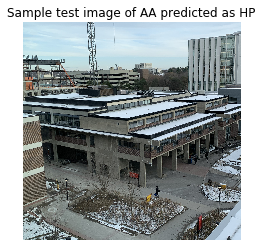

Incorrect...
Predicting class of 'SampleImages/CB_1.jpg' using model '<keras.engine.training.Model object at 0x7fac49c26c50>'
Predicting class of 'SampleImages/CB_1.jpg' using model '<keras.engine.training.Model object at 0x7fac48cf22e8>'
Predicting class of 'SampleImages/CB_1.jpg' using model '<keras.engine.training.Model object at 0x7fac47ca2320>'
Predicting class of 'SampleImages/CB_1.jpg' using model '<keras.engine.training.Model object at 0x7fac46bd3358>'
Predicting class of 'SampleImages/CB_1.jpg' using model '<keras.engine.training.Model object at 0x7fac45b00390>'


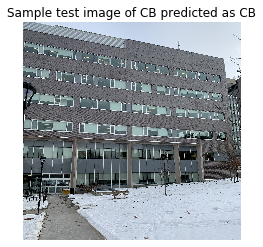

Correct!
Predicting class of 'SampleImages/DT_1.jpg' using model '<keras.engine.training.Model object at 0x7fac49c26c50>'
Predicting class of 'SampleImages/DT_1.jpg' using model '<keras.engine.training.Model object at 0x7fac48cf22e8>'
Predicting class of 'SampleImages/DT_1.jpg' using model '<keras.engine.training.Model object at 0x7fac47ca2320>'
Predicting class of 'SampleImages/DT_1.jpg' using model '<keras.engine.training.Model object at 0x7fac46bd3358>'
Predicting class of 'SampleImages/DT_1.jpg' using model '<keras.engine.training.Model object at 0x7fac45b00390>'


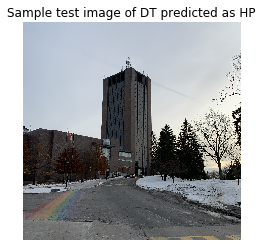

Incorrect...
Predicting class of 'SampleImages/HS_1.jpg' using model '<keras.engine.training.Model object at 0x7fac49c26c50>'
Predicting class of 'SampleImages/HS_1.jpg' using model '<keras.engine.training.Model object at 0x7fac48cf22e8>'
Predicting class of 'SampleImages/HS_1.jpg' using model '<keras.engine.training.Model object at 0x7fac47ca2320>'
Predicting class of 'SampleImages/HS_1.jpg' using model '<keras.engine.training.Model object at 0x7fac46bd3358>'
Predicting class of 'SampleImages/HS_1.jpg' using model '<keras.engine.training.Model object at 0x7fac45b00390>'


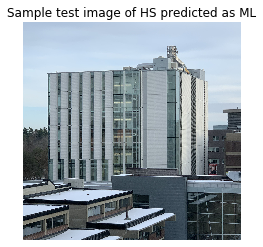

Incorrect...
Expected that worst recall would be on DT
Expected that best precision would be on HP
Expected total accuracy would be 0.910
Actual total accuracy is 0.250


In [0]:
import numpy as np
from PIL import Image, ExifTags
import matplotlib.pyplot as plt
from glob import glob


# First prepare the model:
prepareModel() # Limited to 5 minutes...

# Load (secret) test data into local Colab environment
!wget https://github.com/jrgreen7/SYSC4906/blob/master/Assignments/Assignment3/Images/SampleImages.zip?raw=true
!unzip SampleImages.zip?raw=true #Should create 4 images
test_images = sorted(glob('SampleImages/*.jpg'))
actual_labels = (buildingCodes[0],buildingCodes[1],buildingCodes[3],buildingCodes[6])

# Classify sample test images:
TP = 0
for imgFname,actual_label in (zip(test_images,actual_labels)):
  pred_label = classifyImage(imgFname) # Predict the label of this image file

  # Plot the image with actual and predicted labels
  # Note that we may have to rotate the image, depending on the 
  # orientation of the camera. Use EXIF tags for this:
  im = Image.open(imgFname)
  for orientation in ExifTags.TAGS.keys() : 
    if ExifTags.TAGS[orientation]=='Orientation' : break 
  exif=dict(im._getexif().items())

  if exif[orientation] == 3 : 
    im=im.rotate(180, expand=True)
  elif exif[orientation] == 6 : 
    im=im.rotate(270, expand=True)
  elif exif[orientation] == 8 : 
    im=im.rotate(90, expand=True)

  im = im.convert('RGB') # May not be necessary?

  plt.title("Sample test image of {0:s} predicted as {1:s}".format(actual_label, pred_label))
  plt.imshow(np.asarray(im))
  plt.axis('off')
  plt.show()

  if (pred_label==actual_label):
    print('Correct!')
    TP += 1
  else:
    print("Incorrect...")

# Print the predicted performance:
print("Expected that worst recall would be on {0:s}".format(worstRecall()))
print("Expected that best precision would be on {0:s}".format(bestPrecision()))
print("Expected total accuracy would be {0:.3f}".format(estimatedAccuracy()))
print("Actual total accuracy is {0:.3f}".format((TP)/(len(test_images))))
